# Modelo de Clustering

## Análisis Exploratorio de Datos
En esta primera fase, cargamos los datos y realizamos un análisis inicial para entender su estructura, distribuciones y relaciones. Esto nos ayuda a identificar posibles problemas como valores nulos o escalas de variables muy diferentes.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage

sns.set_style('whitegrid')
df = pd.read_csv('recipe_site_traffic_2212.csv')
print("--- Información General del DataFrame ---")
df.info()
print("\n--- Estadísticas Descriptivas ---")
display(df.describe())

--- Información General del DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB

--- Estadísticas Descriptivas ---


,recipe,calories,carbohydrate,sugar,protein
count,947.000000,895.000000,895.000000,895.000000,895.000000
mean,474.000000,435.939196,35.069676,9.046547,24.149296
std,273.519652,453.020997,43.949032,14.679176,36.369739
min,1.000000,0.140000,0.030000,0.010000,0.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000
50%,474.000000,288.550000,21.480000,4.550000,10.800000
75%,710.500000,597.650000,44.965000,9.800000,30.200000
max,947.000000,3633.160000,530.420000,148.750000,363.360000


El análisis inicial muestra que hay valores nulos en las columnas de nutrientes. Las escalas de las variables numéricas son muy diferentes, lo que requerirá estandarización.

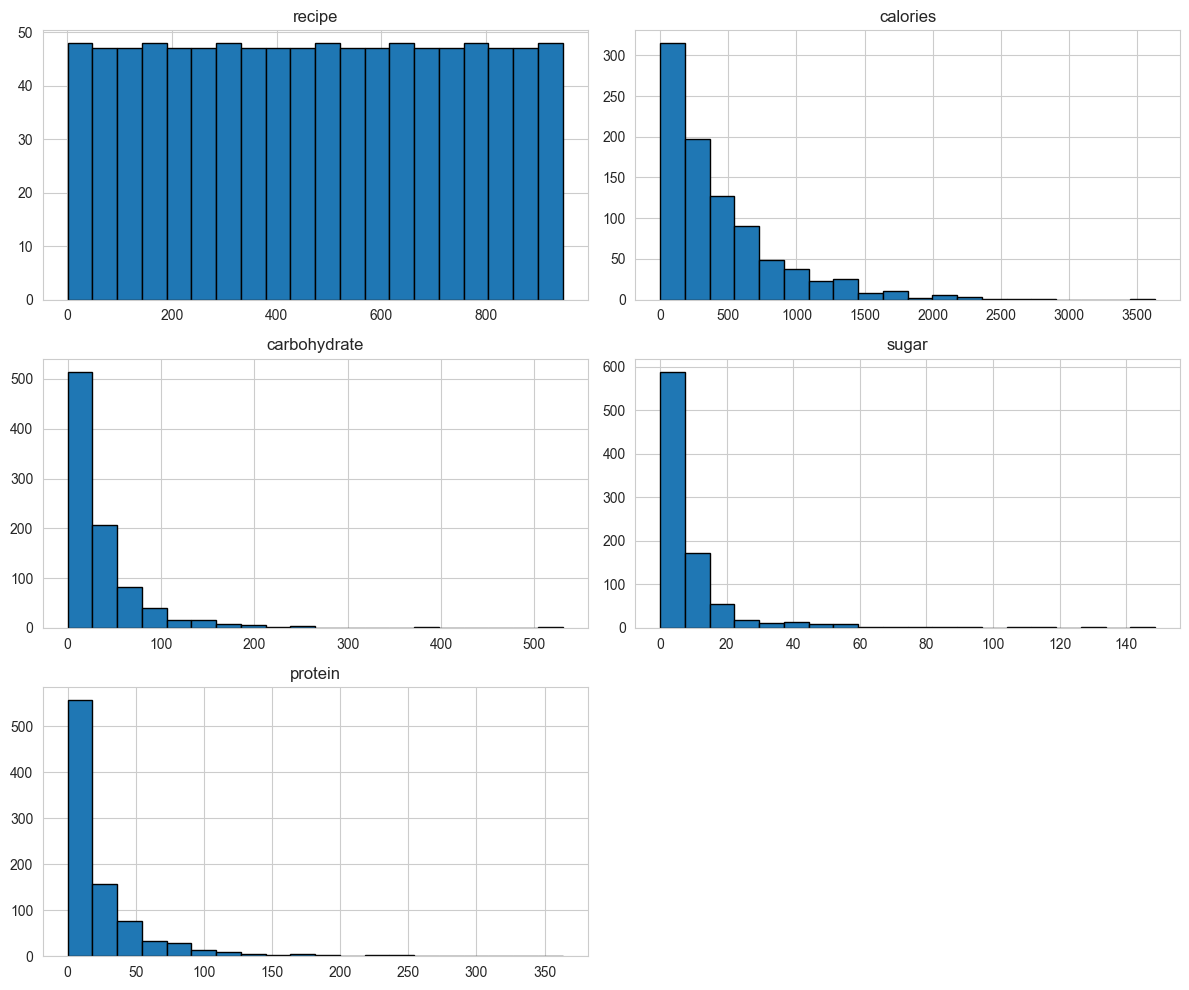

In [29]:
df.hist(figsize=(12, 10), bins=20, edgecolor='black')
plt.tight_layout()
plt.show()

Los histogramas nos dan una idea de la distribución de cada variable. Por ejemplo, `calories` y `protein` están sesgadas a la derecha.

## Preprocesamiento de Datos
Aquí preparamos los datos para el modelado. Esto incluye eliminar valores nulos, convertir variables categóricas a numéricas, y estandarizar las características. También aplicamos PCA para reducir la dimensionalidad.

In [30]:
df_clean = df.copy()
df_clean.dropna(inplace=True)
df_clean = pd.get_dummies(df_clean, columns=['category'], drop_first=True)
df_clean.drop(['recipe', 'high_traffic'], axis=1, inplace=True)
df_clean['servings'] = df_clean['servings'].astype(str).str.extract('(\\d+)').astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

Los datos están ahora limpios, estandarizados y reducidos a dos componentes principales, listos para el clustering.

## Modelado y Análisis de Clustering
### K-Means
K-Means es un algoritmo que agrupa los datos en un número predefinido de clusters (k). Buscamos el 'k' óptimo usando el método del codo y la puntuación de silueta.

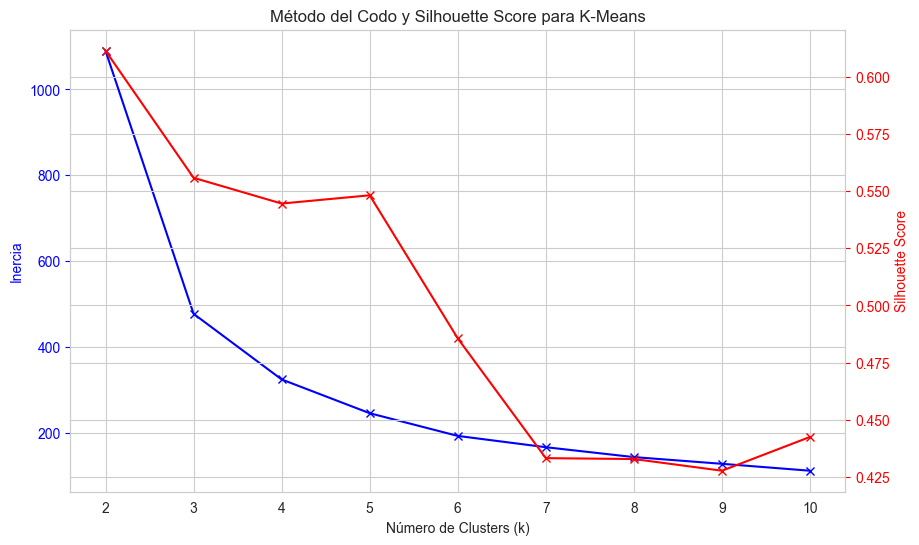

In [31]:
inertia = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca, kmeans.labels_))

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(K, inertia, 'bx-')
ax1.set_xlabel('Número de Clusters (k)')
ax1.set_ylabel('Inercia', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(K, silhouette_scores, 'rx-')
ax2.set_ylabel('Silhouette Score', color='r')
ax2.tick_params('y', colors='r')

plt.title('Método del Codo y Silhouette Score para K-Means')
plt.show()

El gráfico muestra que un `k` de 4 es un buen punto de partida, ya que es donde la inercia comienza a disminuir más lentamente (el 'codo') y la puntuación de silueta es relativamente alta.

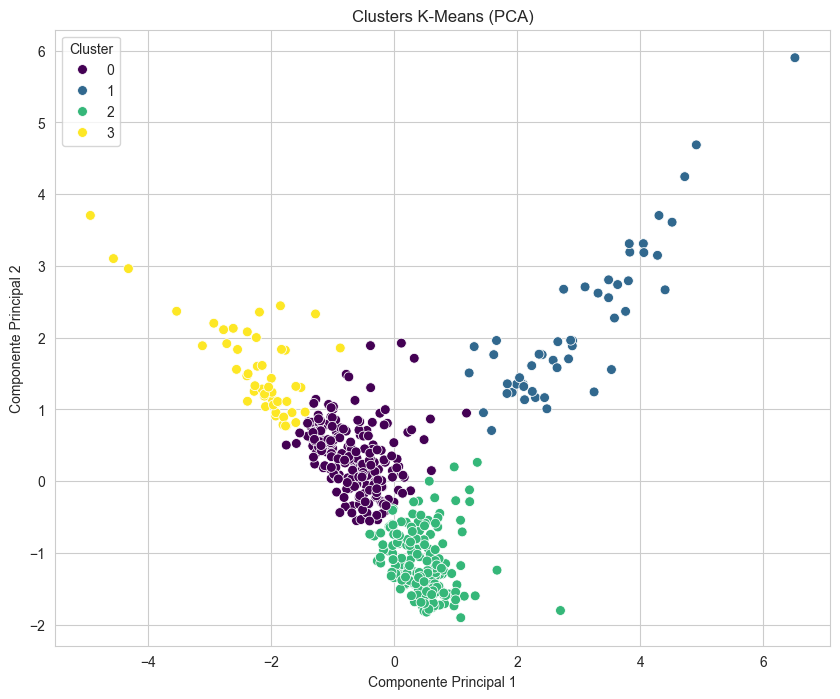

In [32]:
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(X_pca)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters_kmeans, palette='viridis', s=50)
plt.title('Clusters K-Means (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()

### Clustering Jerárquico Aglomerativo
Este método construye una jerarquía de clusters. El dendrograma nos ayuda a visualizar esta jerarquía y a decidir un número de clusters.

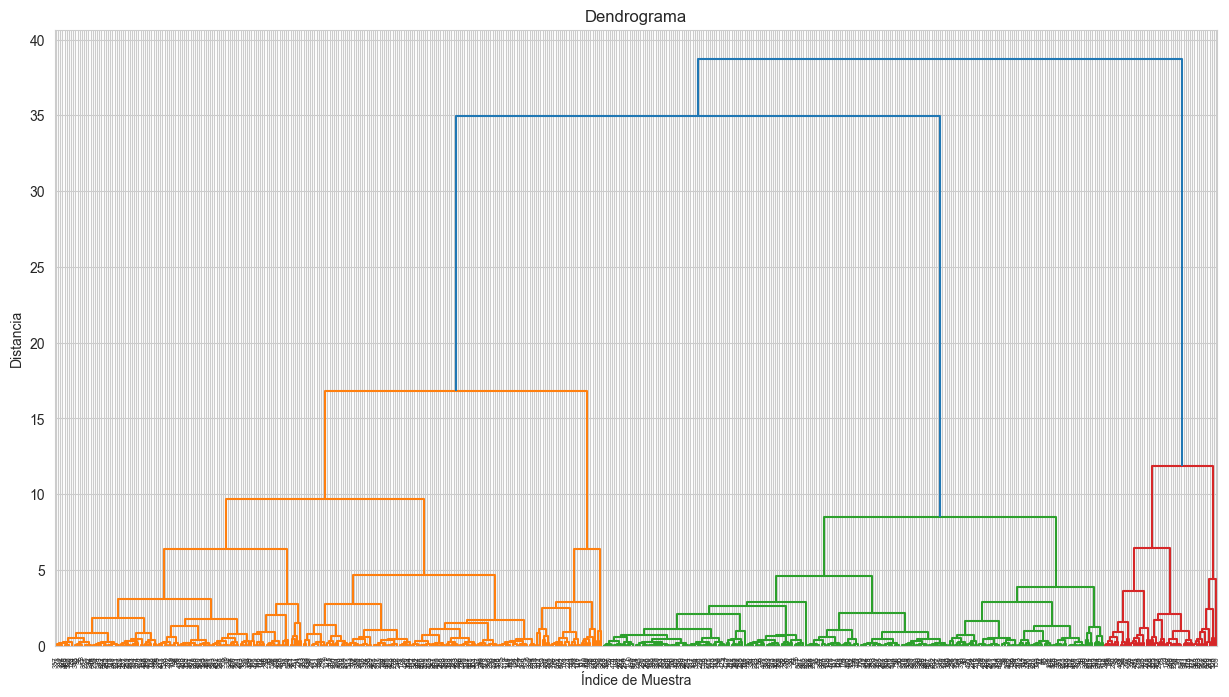

In [33]:
plt.figure(figsize=(15, 8))
linked = linkage(X_pca, method='ward')
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrograma')
plt.xlabel('Índice de Muestra')
plt.ylabel('Distancia')
plt.show()

El dendrograma sugiere que 4 clusters es una opción razonable (cortando el dendrograma donde hay más espacio vertical).

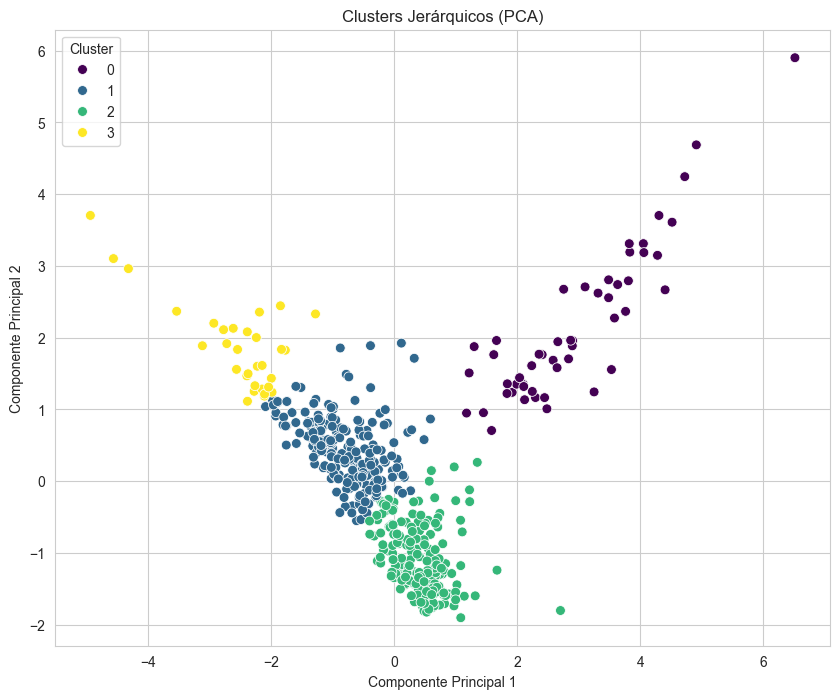

In [34]:
agg_clustering = AgglomerativeClustering(n_clusters=4)
clusters_agg = agg_clustering.fit_predict(X_pca)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters_agg, palette='viridis', s=50)
plt.title('Clusters Jerárquicos (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()

### DBSCAN
DBSCAN agrupa los datos basándose en la densidad y es bueno para encontrar clusters de formas arbitrarias y para identificar ruido (outliers).

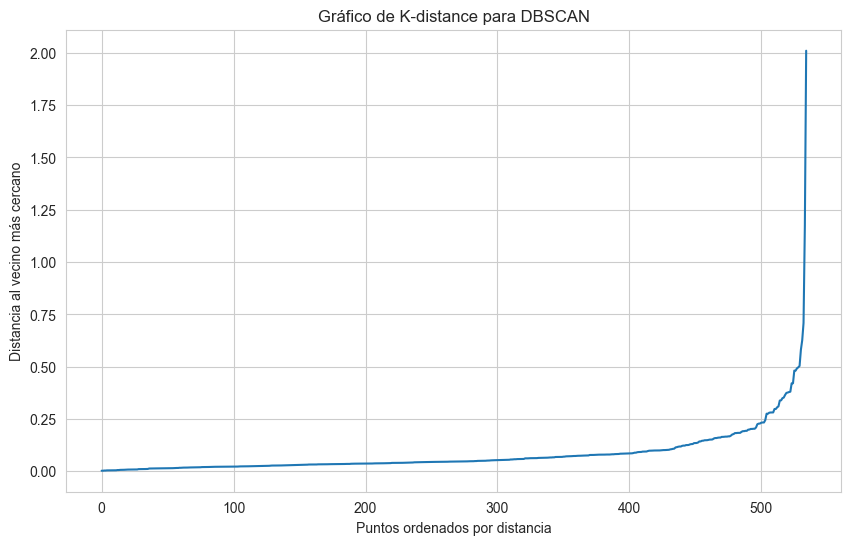

In [35]:
neighbors = NearestNeighbors(n_neighbors=2 * X_pca.shape[1])
neighbors_fit = neighbors.fit(X_pca)
distances, indices = neighbors_fit.kneighbors(X_pca)

distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('Gráfico de K-distance para DBSCAN')
plt.xlabel('Puntos ordenados por distancia')
plt.ylabel('Distancia al vecino más cercano')
plt.show()

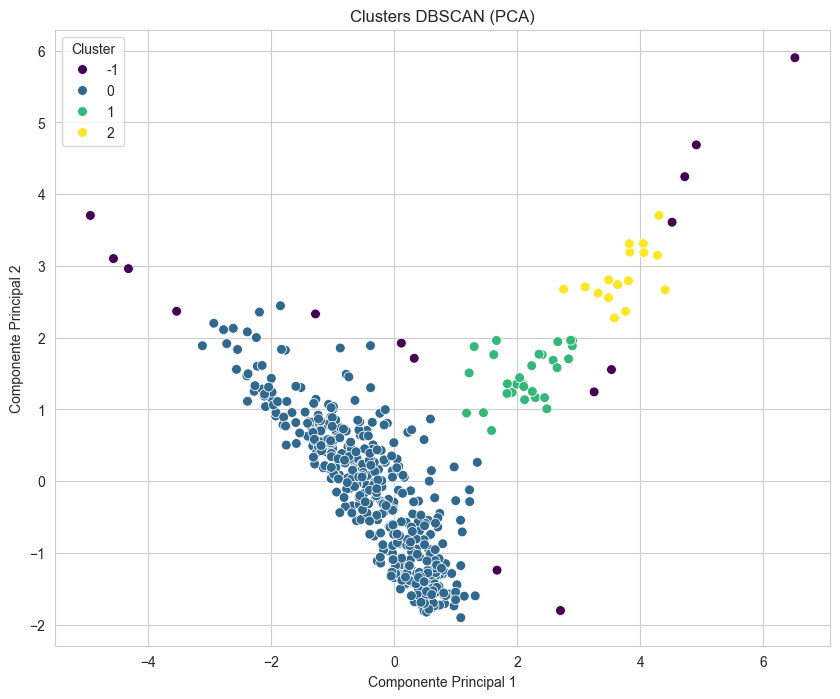

In [36]:
dbscan = DBSCAN(eps=0.5, min_samples=2 * X_pca.shape[1])
clusters_dbscan = dbscan.fit_predict(X_pca)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters_dbscan, palette='viridis', s=50)
plt.title('Clusters DBSCAN (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()

DBSCAN, con los parámetros elegidos, no fue capaz de encontrar una estructura de clusters clara, agrupando la mayoría de los puntos como ruido (0).

## Evaluación y Comparación de Modelos
Comparamos los modelos utilizando métricas numéricas para evaluar la calidad de los clusters. Un Silhouette Score más alto es mejor, mientras que un Davies-Bouldin más bajo es mejor.

In [37]:
results = {}
models = {'K-Means': clusters_kmeans, 'Jerárquico': clusters_agg, 'DBSCAN': clusters_dbscan}

for name, labels in models.items():
    if len(np.unique(labels)) > 1:
        silhouette = silhouette_score(X_pca, labels)
        calinski = calinski_harabasz_score(X_pca, labels)
        davies = davies_bouldin_score(X_pca, labels)
        results[name] = [silhouette, calinski, davies]
    else:
        results[name] = ['N/A', 'N/A', 'N/A']

df_results = pd.DataFrame.from_dict(results, orient='index', columns=['Silhouette Score', 'Calinski-Harabasz', 'Davies-Bouldin'])
display(df_results)

,Silhouette Score,Calinski-Harabasz,Davies-Bouldin
K-Means,0.544559,828.083951,0.591387
Jerárquico,0.544583,783.051941,0.566152
DBSCAN,0.496556,116.160375,2.232661


K-Means y el modelo Jerárquico tienen un rendimiento muy similar, con K-Means ligeramente mejor en la puntuación de silueta. DBSCAN no es adecuado para estos datos.

Basado en los resultados, K-Means con 4 clusters es el modelo recomendado. Es computacionalmente eficiente y proporciona clusters claros y separables que pueden ser interpretados para obtener insights de negocio.